**Промежуточная аттестация**


Вся работа разделена на логические разделы, которые можно увидеть в содержании

**Задание:**

Сравнение классификаторов

Суть задания состоит в том, чтобы сравнить различные классификаторы на наборе данных Extended MNIST https://www.nist.gov/itl/products-and-services/emnist-dataset который содержит монохромные изображения латинских букв. На каждом изображении содержится по одной букве в низком разрешении (28 на 28 пикселей).

Вам нужно использовать 88,800 изображений для обучения и 14,800 изображений, чтобы проверить качество классификации.При тестировании следует применить различные модели, включая (но не ограничиваясь):

-- KNeighborsClassifier

-- LogisticRegression

-- Naive Bayes

-- Bayesian Classifier

-- Linear SVC

-- DecisionTreeClassifier

В этой части требуется провести эксперименты с различными моделями и гиперпараметрами моделей. Оценить качество классификаторов и сравнить их друг с другом по различным метрикам (не только по основной метрике соревнования).

Попробуйте уменьшить размерность пространства при помощи PCA (или других аналогичных) методов и сравнить результаты до и после уменьшения размерности.Результаты решения загрузите в виде jupyter notebook (с вашими комментариями).

Импортирование всех необходимых модулей

In [ ]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from time import time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC

###**Подготовка данных**

Файл для обучения был заранее скачан с kaggle страницы MNIST. С помощью библиотеки `pandas`, а именно его метода `read_csv` датасет был выгружен. При первоначальной выгрузке и осмотре первых пяти элементов было установлено, что набор не имеет заголовков, так как вместо конкретных параметров в столбцах у него находятся значения пикселей, поэтому применился параметр `header=None`. Он не позволил определить первую строку как заголовок.

Датасет для удобства был загружен на Google Drive, который подключен к колабу

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/emnist-letters-train.csv', header=None)
data_test = pd.read_csv('/content/drive/MyDrive/emnist-letters-test.csv', header=None)

С помощью метода `shape` можно узнать, соответствует ли количество элементов в выборках количеству элементов в задании

In [ ]:
print(data_train.shape)
print('------------------------------')
print(data_test.shape)

(88800, 785)
------------------------------
(14800, 785)


Метод `head` позволяет показать, что первый столбец - номер буквы латинского алфавита, которая представлена в последующих столбцах той же строки, что указывалось и в описании MNIST. Поэтому необходимо извлечь данную информацию в соответствующий массив. Для того, чтобы увидеть соержимое ячеек, необходимо снять ограничения на вывод количества столбцов. Ячейки предстаавляют собой значения в диапазоне от 0 до 255, что соответствует значениям пикселей в одноканальных изображениях

In [ ]:
pd.set_option('display.max_columns', None)
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,114,125,82,37,37,39,115,157,94,21,10,32,37,37,37,37,37,37,37,82,125,114,20,0,0,0,3,109,245,249,233,217,217,217,245,251,234,172,142,203,217,217,217,217,217,217,217,233,249,245,109,3,0,0,4,114,253,254,254,254,254,254,254,254,254,252,251,254,254,254,254,254,254,254,254,254,254,254,127,4,0,0,0,45,214,233,251,254,254,254,254,255,255,255,255,255,255,255,255,255,255,255,255,254,254,251,113,4,0,0,0,0,5,22,82,128,160,184,217,217,218,249,254,255,255,255,255,255,254,254,247,216,170,83,7,0,0,0,0,0,0,0,2,5,16,25,37,40,50,227,254,255,255,254,254,252,245,220,159,38,21,3,0,0,0,0,0,0,0,0,0,0,0,0,9,77,140,247,254,254,254,254,244,177,114,50,20,0,0,0,0,0,0,0,0,0,0,0,0,0,3,34,175,246,254,254,254,253,221,115,46,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,34,84,175,251,254,254,253,234,202,91,4,0,0,0,0,0,0,0,0,0,0

Для дальнейшего обучения с помощью методы `iloc` необходимо разделить выборку на две части: массив значений пикселей и массив номеров букв

In [ ]:
train_data = data_train.iloc[:, 1:]
train_y = data_train.iloc[:, 0]

#Заранее разбиваю выборку для итогового тестирования
test_data = data_test.iloc[:, 1:]
test_y = data_test.iloc[:, 0]

С помощью вывода первой строки обучающей выборки можно увидеть, как буква будет выглядить в зависимости от своего положения в массиве

In [ ]:
arr = np.array(train_data[:1])#выбор первой строки в массиве
np.set_printoptions(threshold=sys.maxsize, linewidth=115)#установка опций для вывода
arr = arr.reshape([28,28])#изменение размерности
print(arr)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  20 114 125  82  37  37  39 115 157  94  21  10  32  37  37  37  37  37  37  37  82 125 114  20   0   0]
 [  0   3 109 245 249 233 217 217 217 245 251 234 172 142 203 217 217 217 217 217 217 217 233 249 245 109   3   0]
 [  0   4 114 253 254 254 254 254 254 254 254 254 252 251 254 254 254 254 254 254 254 254 254 254 254 127   4   0]
 [  0   0  45 214 233 251 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 251 113   4   0]
 [  0   0   0   5  22  82 128 160 184 217 217 218 249 254 255 255 255 255 255 254 254 247 216 170  83   7   0   0]
 [  0   0   0   0   0   2   5  16  25  37  40  50 227 254 255 255 254 254 252 24

Для наглядного отображения результатов, был выбран массив из модуля `string`, который содержит в себе буквы латинского алфавита

In [ ]:
import string
alphabet = list(string.ascii_lowercase)
print(alphabet)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Перед началом обучения первые 5 букв были выведены с помощью метода `imshow` и цикла `for`. Массив пикселей, содержащий в себе информацию о букве, был разбит с помощью метода `reshape` и перевернут (метод `transpose`), т.к. изначально буквы были повернуты на 90 градусов вправо

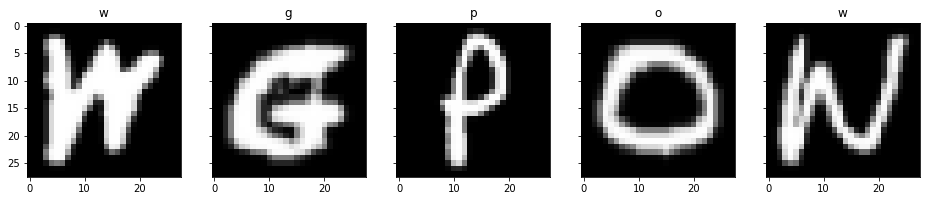

In [ ]:
#объявление пространства для отображения
f, ax = plt.subplots(1, 5, sharey=True, figsize=(16,6))
for i in range(5):
  #выбор i-той буквы из alphabet
  letter_of_alphabet = alphabet[train_y[i]-1]
  #установка заголовка графика в виде названия i-той буквы алфавита
  ax[i].set_title(letter_of_alphabet)
  #отрисовка букв с применением серого фильтра
  ax[i].imshow(np.transpose(np.array(train_data)[i,:].reshape([28,28])), cmap='gray')

Узнав о наличии фильтров для подготовки изображений, были перебраны несколько из них, однако только фильтр Гаусса показал приемлемый результат. Гипотеза была такова: если сгладить края букв, то нахождение букв будет лучше.

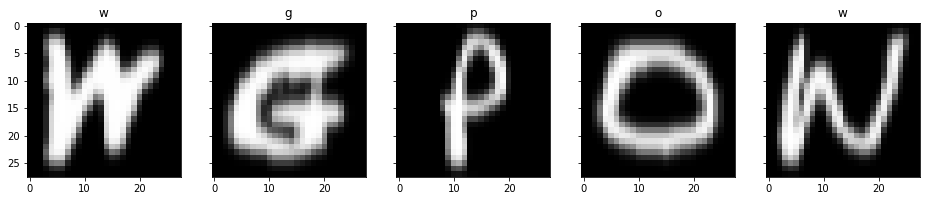

In [ ]:
#применение фильтра на массиве пикселей, значение сигмы наиболее удовлетворительное
train_data = gaussian_filter1d(np.array(train_data), sigma=1)
f, ax = plt.subplots(1, 5, sharey=True, figsize=(16,6))
for i in range(5):
  letter_of_alphabet = alphabet[train_y[i]-1]
  ax[i].set_title(letter_of_alphabet)#название буквы
  ax[i].imshow(np.transpose(train_data[i,:].reshape([28,28])), cmap='gray')

###**PCA**

Для дальнейшего обучения и исследования был вычислен PCA массив, элементы которого в последующем будут сравниваться с элементами обычной выборки

In [ ]:
#инициализация PCA
pca = PCA().fit(train_data)

Для того, чтобы найти наиболее удачное наименьшее количество компонентов, был отприсован график зависимости количетсва компонентов от коэффициента дисперсии. Из графика видно, что дисперсия не изменятся при 200 компонент

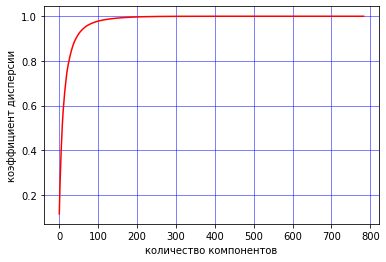

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.grid(color='b', linestyle='-', linewidth=0.5)#объявление сетки
#отрисовка графика PCA
ax.plot(np.cumsum(pca.explained_variance_ratio_), color='r')
plt.xlabel('количество компонентов')
plt.ylabel('коэффициент дисперсии');

После получения всех необходимых массивов, необходимо разделить выборку на часть, которая будет использоваться при обучении, и часть, которая будет использоваться при тестировании перед итоговым тестированием, с помощью метода `train_test_split` в соотношении 70% и 30% соответственно

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_y, test_size=0.3,
random_state=17)

In [ ]:
print('Размер обучающей части выборки: ', X_train.shape)
print('-----------------')
print('Размер тестовой части выборки:  ', X_test.shape)

Размер обучающей части выборки:  (62160, 784)
-----------------
Размер тестовой части выборки:   (26640, 784)


Выше был приведен пример того, как следовало бы разбить выборку, данную для обучения. Однако из гугл диска были загружены уже заранее разбитые на части две выборки: для обучения и для тестирования

In [ ]:
X_train = train_data
X_test = test_data
y_train = train_y
y_test = test_y

Обучение PCA на выбранных 200 компонент

In [ ]:
pca = PCA(200).fit(X_train)

Трансформирование разделенных частей выборки в соответствии с PCA

In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
print("Исходный размер:   ", X_train.shape)
print("Измененный размер: ", X_train_pca.shape)

Исходный размер:    (88800, 784)
Измененный размер:  (88800, 200)


После чего имеются две выборки `X_train` и `X_train_pca`, на которых будет проводится обучение, и `y_train` с `y_test` массивы для нахождения правильности обучения

###**KNN**

Во время применения данного классификатора были рассмотрены несколько метрик для нахождения расстояния между ближайшими соседями. Метрики выбирались в соответствии со статьей по ссылке ниже. Из всех метрик хорошо подошло нахождение косинусное расстояние, т.к. при этом процент accuracy на тестовой выборке повышается в среднем на 0.2.

Ссылка первоисточника: https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html

In [ ]:
#создаём каркас для модели KNN
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1, metric='cosine', algorithm='brute'))])

Заранее параметры были рассмотрены в диапазоне от 1 до 15, но наиболее качетсвенные результаты были в диапазоне от 9 до 11. Поэтому в данной работе рассматривается именно этот диапазон количества соседей

In [ ]:
#передаём параметры для модели, которые будут перебираться
knn_params = {'knn__n_neighbors': range(9, 11)}

Для обучения применяется 5-кратная кросс-валидация с помощью класса `GridSearchCV`

In [ ]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

Для того, чтобы сравнить результаты всех моделей, идёт подсчет времени выполнения алгоритма с использованием PCA

In [ ]:
start = time()
knn_grid.fit(X_train_pca, y_train)
exec_time_knn_pca = time() - start

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Лучший результат, полученный с помощью модели

In [ ]:
print('Количество ближайших соседей: ', knn_grid.best_params_)
print('Лучший результат: ', knn_grid.best_score_)

Количество ближайших соседей:  {'knn__n_neighbors': 10}
Лучший результат:  0.7308075933075934


Для оценки модели рассмотрены несколько основных метрик. В целом значения метрик приблизительно одинаковы

In [ ]:
print('accuracy: ', accuracy_score(y_test, knn_grid.predict(X_test_pca)))
print('precision: ', precision_score(y_test, knn_grid.predict(X_test_pca), average='weighted') )
print('recall: ', recall_score(y_test, knn_grid.predict(X_test_pca), average='weighted'))
print('f1: ', f1_score(y_test, knn_grid.predict(X_test_pca), average='weighted'))

accuracy:  0.7383633633633634
precision:  0.7468406859252321
recall:  0.7383633633633634
f1:  0.7382058889547832


Для чистоты эксперимента обучение проводилось и без PCA для всех компонент

In [ ]:
start = time()
knn_grid.fit(X_train, y_train)
exec_time_knn = time() - start

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Лучший результат, полученный с помощью модели

In [ ]:
print('Количество ближайших соседей: ', knn_grid.best_params_)
print('Лучший результат: ', knn_grid.best_score_)

Количество ближайших соседей:  {'knn__n_neighbors': 9}
Лучший результат:  0.8114060489060488


Pначения метрик также приблизительно одинаковы на тестовой выборке

In [ ]:
print('accuracy: ', accuracy_score(y_test, knn_grid.predict(X_test)))
print('precision: ', precision_score(y_test, knn_grid.predict(X_test), average='weighted') )
print('recall: ', recall_score(y_test, knn_grid.predict(X_test), average='weighted'))
print('f1: ', f1_score(y_test, knn_grid.predict(X_test), average='weighted'))

accuracy:  0.815015015015015
precision:  0.818227170687979
recall:  0.815015015015015
f1:  0.8148728293166928


Без использования PCA результат лучше, однако обучение занимает дольше времени

In [ ]:
print('Время обучения KNN без PCA: ', exec_time_knn)
print('Время обучения KNN с PCA  : ', exec_time_knn_pca)

Время обучения KNN без PCA:  636.9096057415009
Время обучения KNN с PCA  :  381.20051741600037


##**Логистическая регрессия**

Для того, чтобы применить кросс-валидацию для логистической регрессии использовался класс `GridSearchCV` и `LogisticRegression`. Также использовались параметры `C`

In [ ]:
#массив значений переменной C
logit_params = {'C': [1, 10, 100]}
#инициализация экземпляра класса валидации
logit = GridSearchCV(LogisticRegression(n_jobs=-1, random_state=17), param_grid=logit_params, cv=5, n_jobs=-1, verbose = True)

Обучение модели с использованием PCA

In [ ]:
start = time()
logit.fit(X_train_pca, y_train)
exec_time_logit_pca = time() - start

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
print('Лучший результат: ', logit.best_score_)

Лучший результат:  0.7058558558558559


Результат логистической регресии хуже, чем KNN, смотря на метрики

In [ ]:
print('accuracy: ', accuracy_score(y_test, logit.predict(X_test_pca)))
print('precision: ', precision_score(y_test, logit.predict(X_test_pca), average='weighted') )
print('recall: ', recall_score(y_test, logit.predict(X_test_pca), average='weighted'))
print('f1: ', f1_score(y_test, logit.predict(X_test_pca), average='weighted'))

accuracy:  0.7102477477477478
precision:  0.7091074260091347
recall:  0.7102477477477478
f1:  0.7089017258845601


Также обучение алгоритма без использования PCA

In [ ]:
start = time()
logit.fit(X_train, y_train)
exec_time_logit = time() - start

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print('Лучший результат: ', logit.best_score_)

Лучший результат:  0.7017535392535393


In [ ]:
print('accuracy: ', accuracy_score(y_test, logit.predict(X_test)))
print('precision: ', precision_score(y_test, logit.predict(X_test), average='weighted') )
print('recall: ', recall_score(y_test, logit.predict(X_test), average='weighted'))
print('f1: ', f1_score(y_test, logit.predict(X_test), average='weighted'))

accuracy:  0.7079579579579579
precision:  0.705892477386376
recall:  0.7079579579579579
f1:  0.7062691022689713


Оценивая результаты метрик и время, потраченное на обучение, можно сказать, что использование PCA не улучшило предсказательную способность модели, а даже ухудшило

In [ ]:
print('Время обучения KNN без PCA: ', exec_time_logit)
print('Время обучения KNN с PCA  : ', exec_time_logit_pca)

Время обучения KNN без PCA:  479.961740732193
Время обучения KNN с PCA  :  184.0858986377716


##**Наивный Байес**

Как и в предыдущих моделях для кросс-валидации применялся класс `GridSearchCV`

In [ ]:
#параметры классификатора
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
#инициализация экземпляра класса валидации
NB_grid = GridSearchCV(GaussianNB(), param_grid=params_NB, cv=5, n_jobs=-1, verbose = True)

In [ ]:
start = time()
NB_grid.fit(X_train_pca, y_train)
exec_time_NB_pca = time() - start

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
print('Лучший результат: ', NB_grid.best_score_)

Лучший результат:  0.5175032175032175


Сразу видно, что для данного типа задачи применение наивного байеса не дает хороших результатов

In [ ]:
print('accuracy: ', accuracy_score(y_test, NB_grid.predict(X_test_pca)))
print('precision: ', precision_score(y_test, NB_grid.predict(X_test_pca), average='weighted') )
print('recall: ', recall_score(y_test, NB_grid.predict(X_test_pca), average='weighted'))
print('f1: ', f1_score(y_test, NB_grid.predict(X_test_pca), average='weighted'))

accuracy:  0.5129504504504504
precision:  0.5493937974827796
recall:  0.5129504504504504
f1:  0.5143795937645333


Также необходимо провести обучение без примененеия PCA

In [ ]:
start = time()
NB_grid.fit(X_train, y_train)
exec_time_NB = time() - start

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print('Лучший результат: ', NB_grid.best_score_)

Лучший результат:  0.5508365508365509


In [ ]:
print('accuracy: ', accuracy_score(y_test, NB_grid.predict(X_test)))
print('precision: ', precision_score(y_test, NB_grid.predict(X_test), average='weighted') )
print('recall: ', recall_score(y_test, NB_grid.predict(X_test), average='weighted'))
print('f1: ', f1_score(y_test, NB_grid.predict(X_test), average='weighted'))

accuracy:  0.5506756756756757
precision:  0.5695905817690674
recall:  0.5506756756756757
f1:  0.5435519448914707


Для чистоты исследования также стоит узнать время обучения. Так, время обучения находится в диапазоне обучения логистической регрессии и метода ближайших соседей, однако результаты метрик намного хуже результатов других моделей

In [ ]:
print('Время обучения KNN без PCA: ', exec_time_NB)
print('Время обучения KNN с PCA  : ', exec_time_NB_pca)

Время обучения KNN без PCA:  771.6265654563904
Время обучения KNN с PCA  :  191.12432861328125


##**SVM**

В задании было указано использовать `Linear SVC`, однако использование этого класса показало плохой результат, поэтому в данном случае используется `SVC`. Также используется 5-кратная кросс-валидация и параметры `C = [1; 10; 100]`

In [ ]:
svm_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
svm_params = {'C': [1,10,100]}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, n_jobs=-1, refit = True, verbose = 3)

Обучение модели с использованием PCA

In [ ]:
start = time()
svm_grid.fit(X_train_pca, y_train)
exec_time_svm_pca = time() - start

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Из вывода видно, что лучшим параметром `C` является 10

In [ ]:
print('Лучший из параметров: ', svm_grid.best_params_)
print('Лучший результат: ', svm_grid.best_score_)

Лучший из параметров:  {'C': 10}
Лучший результат:  0.9087516087516088


Метрики показывают наилучший результат из всех использованных ранее моделей

In [ ]:
print('accuracy: ', accuracy_score(y_test, svm_grid.predict(X_test_pca)))
print('precision: ', precision_score(y_test, svm_grid.predict(X_test_pca), average='weighted') )
print('recall: ', recall_score(y_test, svm_grid.predict(X_test_pca), average='weighted'))
print('f1: ', f1_score(y_test, svm_grid.predict(X_test_pca), average='weighted'))

accuracy:  0.9114864864864864
precision:  0.9120246435829582
recall:  0.9114864864864864
f1:  0.9116198816259585


Также была проведена проверка обучения без использования PCA

In [ ]:
start = time()
svm_grid.fit(X_train, y_train)
exec_time_svm = time() - start

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print('Лучший из параметров: ', svm_grid.best_params_)
print('Лучший результат: ', svm_grid.best_score_)

Лучший из параметров:  {'C': 10}
Лучший результат:  0.9070141570141569


Результаты использования полного набора компонент говорит о том, что с использованием PCA классификация производится на `0.01` лучше

In [ ]:
print('accuracy: ', accuracy_score(y_test, svm_grid.predict(X_test)))
print('precision: ', precision_score(y_test, svm_grid.predict(X_test), average='weighted') )
print('recall: ', recall_score(y_test, svm_grid.predict(X_test), average='weighted'))
print('f1: ', f1_score(y_test, svm_grid.predict(X_test), average='weighted'))

accuracy:  0.9103978978978979
precision:  0.9109021288708731
recall:  0.9103978978978979
f1:  0.9105258392812394


Из минусов следует отметить время, затраченное на обучение. Результат представлен в секундах, однако при переводе это время равно порядка двух часов без использования GPU и каких-либо модификаций

In [ ]:
print('Время обучения SVM без PCA: ', exec_time_svm)
print('Время обучения SVM с PCA  : ', exec_time_svm_pca)

Время обучения SVM без PCA:  10605.814685583115
Время обучения SVM с PCA  :  3668.7050099372864


##**Дерево решений**

При реализации дерева решений следует сказать о предубеждении о том, что вместо него будет лучше работать случайный лес. Ниже в коде представлены наиболее лучшие параметры, которые были заранее расчитаны из диапазона от 1 до 20, поэтому представлены только диапазоны с наилучшим результатом

In [ ]:
tree_params = {'max_depth': range(9,11),
               'max_features': range(17,19)}

Дерево решений обучается с помощью класса `DecisionTreeClassifier` с использованием кросс-валидации

In [ ]:
tree_grid = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), tree_params, cv=5, n_jobs=-1, verbose=True)

Обучение с использованием PCA

In [ ]:
start = time()
tree_grid.fit(X_train_pca, y_train)
exec_time_tree_pca = time() - start

Fitting 5 folds for each of 4 candidates, totalling 20 fits


С использованием PCA лучший результат не достиг даже 50%, что можно увидеть также и из реализации метрик

In [ ]:
print('Лучший из параметров: ', tree_grid.best_params_)
print('Лучший результат: ', tree_grid.best_score_)

Лучший из параметров:  {'max_depth': 10, 'max_features': 17}
Лучший результат:  0.36558880308880315


In [ ]:
print('accuracy: ', accuracy_score(y_test, tree_grid.predict(X_test_pca)))
print('precision: ', precision_score(y_test, tree_grid.predict(X_test_pca), average='weighted') )
print('recall: ', recall_score(y_test, tree_grid.predict(X_test_pca), average='weighted'))
print('f1: ', f1_score(y_test, tree_grid.predict(X_test_pca), average='weighted'))

accuracy:  0.38506006006006005
precision:  0.3940266415508918
recall:  0.38506006006006005
f1:  0.38306325776377853


Обучение без использования PCA

In [ ]:
start = time()
tree_grid.fit(X_train, y_train)
exec_time_tree = time() - start

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
print('Лучший из параметров: ', tree_grid.best_params_)
print('Лучший результат: ', tree_grid.best_score_)

Лучший из параметров:  {'max_depth': 10, 'max_features': 18}
Лучший результат:  0.5920527670527671


Без использования PCA модель смогла правильно классифицировать только половину всей выборки, что является лучшим результатом, чем с применением уменьшения размерности

In [ ]:
print('accuracy: ', accuracy_score(y_test, tree_grid.predict(X_test)))
print('precision: ', precision_score(y_test, tree_grid.predict(X_test), average='weighted') )
print('recall: ', recall_score(y_test, tree_grid.predict(X_test), average='weighted'))
print('f1: ', f1_score(y_test, tree_grid.predict(X_test), average='weighted'))

accuracy:  0.5829204204204205
precision:  0.5862175909580654
recall:  0.5829204204204205
f1:  0.5806963141981458


In [ ]:
from sklearn.ensemble import RandomForestClassifier

Для примера также был рассмотрен случайный лес, однако его показатель не превысил 82% процентов, что говорит о том, что модель SVM всё также лучше классифицирует данные

In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [ ]:
accuracy_score(y_test, rf.predict(X_test_pca))

0.8179429429429429

## **Результат**

Во время обучения наилучшим образом показал себя алгоритм SVM, поэтому именно он был применен для классификации итоговой выборки. Ниже представлен пример первых 5 букв тестовой выборки. Они представляют собой буквы "А" в строчном и прописном виде

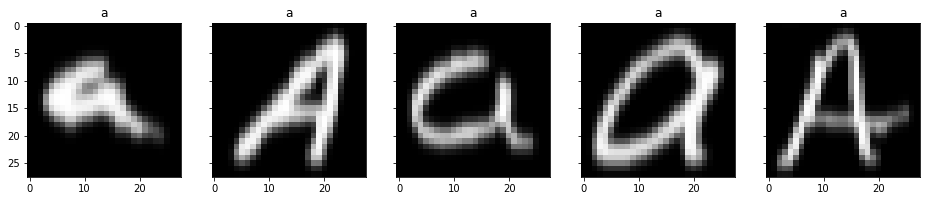

In [ ]:
test_data = gaussian_filter1d(np.array(test_data), sigma=1)
f, ax = plt.subplots(1, 5, sharey=True, figsize=(16,6))
for i in range(5):
  letter_of_alphabet = alphabet[test_y[i]-1]
  ax[i].set_title(letter_of_alphabet)#название буквы
  ax[i].imshow(np.transpose(test_data[i,:].reshape([28,28])), cmap='gray')

Уменьшение размерности компонент выборки

In [ ]:
X_pca = pca.transform(test_data)

In [ ]:
print("Исходный размер:   ", test_data.shape)
print("Измененный размер: ", X_pca.shape)

Исходный размер:    (14800, 784)
Измененный размер:  (14800, 200)


Классификация выборки с помощью обученной модели SVM

In [ ]:
y_results_svm = svm_grid.predict(test_data)

Результат метрик на итоговой выборке превышает 80% по каждой из них

In [ ]:
print('accuracy: ', accuracy_score(test_y, y_results_svm))
print('precision: ', precision_score(test_y, y_results_svm, average='weighted') )
print('recall: ', recall_score(test_y, y_results_svm, average='weighted'))
print('f1: ', f1_score(test_y, y_results_svm, average='weighted'))

accuracy:  0.8970270270270271
precision:  0.9069910888221346
recall:  0.8970270270270271
f1:  0.9016868140465167


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Также стоит показать первые 10 букв выборки в соответствии с классифицированными выше буквами. Стоит отметить, что букву "А" модель определила правильно

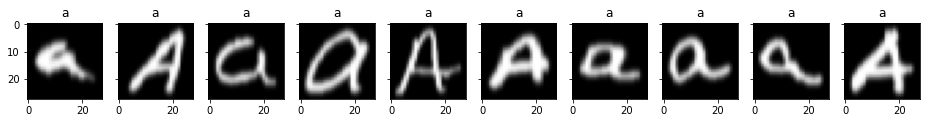

In [ ]:
f, ax = plt.subplots(1, 10, sharey=True, figsize=(16,6))
for i in range(10):
  letter_of_alphabet = alphabet[y_results_svm[i]-1]
  ax[i].set_title(letter_of_alphabet)#название буквы
  ax[i].imshow(np.transpose(test_data[i,:].reshape([28,28])), cmap='gray')

Метод для нахождения индексов неправильно классифицированных букв

In [ ]:
def array_errors(y_results, test_y):
  arr_errors = []
  for i, (result, test) in enumerate(zip(y_results, test_y)):
    if test != result:
      arr_errors.append(i)
  return arr_errors

In [ ]:
#вызов метода
errors = array_errors(y_results_svm, test_y)

1524

Отображение неправильно классифицированных алгоритмом букв. Можно заметить, что это буквы, имеющие большой наклон или написанные не так однозначно. Также стоит отметить, что из 14800 элементов неправильно классифицированы были 1524

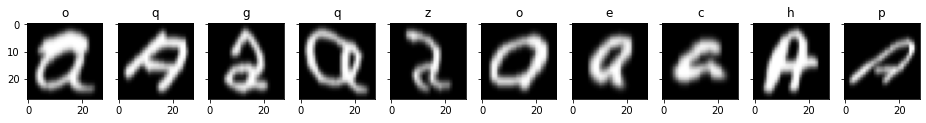

In [ ]:
f, ax = plt.subplots(1, 10, sharey=True, figsize=(16,6))
for i in range(10):
  letter_of_alphabet = alphabet[y_results_svm[errors[i]]-1]
  ax[i].set_title(letter_of_alphabet)#название буквы
  ax[i].imshow(np.transpose(test_data[errors[i],:].reshape([28,28])), cmap='gray')

Для интереса была рассмотрена модель knn на итоговой выборке. Метрика точности составила около 72% правильно классифицированных букв

In [ ]:
accuracy_score(test_y, knn_grid.predict(X_pca))

0.724527027027027

Теперь необходимо провести обучение для дальнейшего сохранения её в csv файл и загрузки на kaggle

In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/emnist-letters-test-data.csv')

Просмотр первых 10 элементов показал, что в файле имеется заголовок и первый столбец с порядковыми индексами, которые необходимо убрать

In [ ]:
data_test.head(10)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,21,32,37,37,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,22,110,172,203,217,214,138,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,45,114,145,232,252,254,254,232,93,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,67,122,203,222,249,254,254,250,207,51,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,47,175,231,254,254,253,232,209,142,111,119,93,53,18,0,0,0,0,0,0,0,0,0,0,0,0,0,33,190,247,253,254,253,219,98,54,77,177,243,236,165,81,2,0,0,0,0,0,0,0,0,0,0,0,3,84,233,254,254,254,228,126,91,118,188,250,254,254,215,125,4,0,0,0,0,0,0,0,0,0,0,0,20,169,251,254,255,253,218,213,233,245,252,254,255,254,222,140,9,0,0,0,0,0,0,0,0,0,0,0,27,190,2

In [ ]:
#сохранение только значений яркости пикселей
test_data = data_test.iloc[:, 1:]

Просмотр первых пяти букв и последующее применение для них фильтра

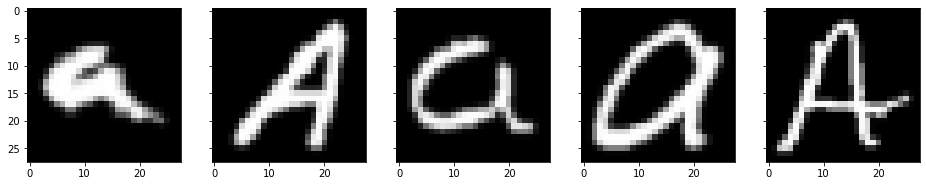

In [ ]:
#объявление пространства для отображения
f, ax = plt.subplots(1, 5, sharey=True, figsize=(16,6))
for i in range(5):
  #отрисовка букв с применением серого фильтра
  ax[i].imshow(np.array(test_data)[i,:].reshape([28,28]), cmap='gray')

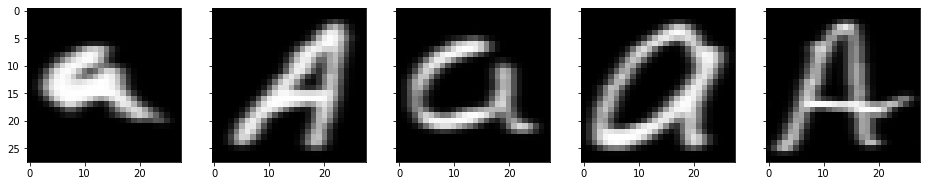

In [ ]:
test_data = gaussian_filter1d(np.array(test_data), sigma=1)
f, ax = plt.subplots(1, 5, sharey=True, figsize=(16,6))
for i in range(5):
  ax[i].imshow(test_data[i,:].reshape([28,28]), cmap='gray')

In [ ]:
X_pca = pca.transform(test_data)

Проверка размерности выборки

In [ ]:
print("Исходный размер:   ", test_data.shape)
print("Измененный размер: ", X_pca.shape)

Исходный размер:    (20800, 784)
Измененный размер:  (20800, 200)


Классиикация выборки для дальнейшего сохранения

In [ ]:
y_results = svm_grid.predict(X_pca)

Сохраняем результат в csv файл

In [ ]:
control_csv = pd.DataFrame(enumerate(y_results), columns=['id', 'class'])
control_csv.to_csv('emnist-letters-predict.csv', index=False)

Таким образом, наилучший алгоритм для классификации букв, представленных в итоговой выборке (14800), это SVM, точность которого составила 0.8970270270270271 (accuracy). Применение PCA в данном случае помогает увеличить точность, однако обучение занимает достаточно длительное время при применении кросс-валидации и без неё.

Спасибо за проверенную работу